# Baseline Modeling

We've completed our initial data cleaning and EDA, and now we'll be completing final data preparation/pre-processing, feature engineering, and running a baseline logistic regression model. 

Let's start by importing our two datasets.

In [70]:
# Import basic packages 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [71]:
# Load metadata
metadata = pd.read_json('data/model_data/metadata.json', lines=True)

In [72]:
# Load reviews data
reviews = pd.read_json('data/model_data/reviews.json', lines=True)

In [73]:
# Sanity check 
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49378 entries, 0 to 49377
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   imdb_id               49378 non-null  object 
 1   title                 49378 non-null  object 
 2   actors                49378 non-null  object 
 3   directors             49378 non-null  object 
 4   genres                49378 non-null  object 
 5   language_en           49378 non-null  int64  
 6   year                  49378 non-null  int64  
 7   runtime               49378 non-null  int64  
 8   budget                17818 non-null  float64
 9   box_office_gross      21049 non-null  float64
 10  production_companies  49378 non-null  object 
 11  votes                 49378 non-null  int64  
 12  rating                49378 non-null  float64
 13  rating_category       49378 non-null  object 
 14  decade                49378 non-null  int64  
dtypes: float64(3), int6

In [74]:
# Sanity check 
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3146437 entries, 0 to 3146436
Data columns (total 5 columns):
 #   Column           Dtype  
---  ------           -----  
 0   imdb_id          object 
 1   review_text      object 
 2   rating           float64
 3   rating_category  object 
 4   review_length    int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 120.0+ MB


We'll start by creating a new dataframe for our modeling data. The first step is for us to add a "count of reviews" feature to the final dataframe that we'll use to normalize the amount of review text per movie. 

Then we will combine our review text with our meatdata in a new dataframe.

In [75]:
# Count the number of reviews per 'imdb_id'
count_reviews = reviews.groupby('imdb_id')['review_text'].count().reset_index()
count_reviews = count_reviews.rename(columns={'review_text': 'review_count'})

In [76]:
# Group reviews by 'imdb_id'
grouped_reviews = reviews.groupby('imdb_id')['review_text'].agg(' '.join).reset_index()

In [77]:
# Add the review count to the grouped_reviews
grouped_reviews = grouped_reviews.merge(count_reviews, on='imdb_id', how='left')

In [78]:
# Join with metadata 
final_df = metadata.merge(grouped_reviews, on='imdb_id', how='inner')

In [79]:
# Sanity check
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49378 entries, 0 to 49377
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   imdb_id               49378 non-null  object 
 1   title                 49378 non-null  object 
 2   actors                49378 non-null  object 
 3   directors             49378 non-null  object 
 4   genres                49378 non-null  object 
 5   language_en           49378 non-null  int64  
 6   year                  49378 non-null  int64  
 7   runtime               49378 non-null  int64  
 8   budget                17818 non-null  float64
 9   box_office_gross      21049 non-null  float64
 10  production_companies  49378 non-null  object 
 11  votes                 49378 non-null  int64  
 12  rating                49378 non-null  float64
 13  rating_category       49378 non-null  object 
 14  decade                49378 non-null  int64  
 15  review_text        

In [80]:
# Check
final_df.head()

,imdb_id,title,actors,directors,genres,language_en,year,runtime,budget,box_office_gross,production_companies,votes,rating,rating_category,decade,review_text,review_count
0,tt0004972,The Birth of a Nation,"[Lillian Gish,Mae Marsh,Henry B. Walthall,Miri...",[D.W. Griffith],"[Drama, History, War]",1,1915,195,100000.000,10000000.000,[Epoch Film Co.],25782,6.200,Average,1910,unbelievable; I cannot understand how anyone c...,329
1,tt0023622,Trouble in Paradise,"[Miriam Hopkins,Kay Francis,Herbert Marshall,C...",[Ernst Lubitsch],"[Comedy, Crime, Romance]",1,1932,83,519706.000,1035500.000,[Paramount],15707,8.000,Excellent,1930,I'm still starry-eyed from it; I saw this last...,64
2,tt0118688,Batman & Robin,"[Arnold Schwarzenegger,George Clooney,Chris OD...",[Joel Schumacher],"[Action, Sci-Fi]",1,1997,125,125000000.000,107325195.000,"[DC Comics, PolyGram Filmed Entertainment, War...",263149,3.800,Poor,1990,Failed on every Front; Joel Schumacher who did...,1675
3,tt0346491,Alexander,"[Colin Farrell,Anthony Hopkins,Rosario Dawson,...",[Oliver Stone],"[Action, Biography, Drama]",1,2004,175,155000000.000,34297191.000,"[France 3 Cinéma, WR Universal Group, Warner B...",173996,5.600,Average,2000,"Poor Casting, Poor script Poor direction.; I h...",1399
4,tt0094721,Beetlejuice,"[Alec Baldwin,Geena Davis,Michael Keaton,Annie...",[Tim Burton],"[Comedy, Fantasy]",1,1988,92,15000000.000,73707461.000,"[Warner Bros. Pictures, Geffen Pictures]",321436,7.500,Excellent,1980,An Accomplished Tim Burton Movie; A Great Idea...,320


##### Train Test Split 
Now that we have our final dataframe with concatenated review text for each movie, the next step is to complete our train test split before doing any feature engineering.

In [81]:
from sklearn.model_selection import train_test_split

# Splitting the data into 80% training and 20% testing
train_df, test_df = train_test_split(final_df, test_size=0.2, random_state=42)

We'll bring over the feature engineering task list that we created during EDA: 

#### Feature Engineering Task List
To summarize the decisioncs we've made regarding feature engineering: 
- ~Bin Ratings into categories using quantiles~ 
    - Drop `ratings` feature 
- ~Bin `year` into decades~ 
    - Drop `year` feature
- For `actors`, `directors`, and `production_companies`, gather top 10 and one hot encode 
    - Drop original columns 
- For `genres`, explode out into columns and one hot encode to retain all genre information 
- Drop `title` 
- Keep `votes`, `budget`, and `box_office_gross` as integers 
- Keep `runtime` as integer 

We'll start by dropping the year, rating, and title columns. We have binned the ratings into categories (because we're focusing on classification), and binned the years into decades to simplify features. Title will not be a predictive feature in our model.

In [82]:
# Drop ratings, year, and title features 
train_df = train_df.drop(columns=['year', 'rating', 'title'])
test_df = test_df.drop(columns=['year', 'rating', 'title'])

#### Decade 
We decided to use decade as a categorical vs numerical feature, to attempt to capture non-linear relationships in the data. Since decade is currently stored as an integer, we'll first convert to a string and then one hot encode each of the decade columns.

In [83]:
# Convert decade to strings
train_df['decade'] = train_df['decade'].astype(str)
test_df['decade'] = test_df['decade'].astype(str)

In [84]:
# One hot encode decade 

# For train dataset
train_decade_dummies = pd.get_dummies(train_df['decade'], prefix='decade')
train_df = pd.concat([train_df, train_decade_dummies], axis=1)

# For test dataset
test_decade_dummies = pd.get_dummies(test_df['decade'], prefix='decade')
test_df = pd.concat([test_df, test_decade_dummies], axis=1)

In [85]:
# Drop original decade column
train_df.drop('decade', axis=1, inplace=True)
test_df.drop('decade', axis=1, inplace=True)

In [86]:
# Check
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39502 entries, 21268 to 15795
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   imdb_id               39502 non-null  object 
 1   actors                39502 non-null  object 
 2   directors             39502 non-null  object 
 3   genres                39502 non-null  object 
 4   language_en           39502 non-null  int64  
 5   runtime               39502 non-null  int64  
 6   budget                14251 non-null  float64
 7   box_office_gross      16792 non-null  float64
 8   production_companies  39502 non-null  object 
 9   votes                 39502 non-null  int64  
 10  rating_category       39502 non-null  object 
 11  review_text           39502 non-null  object 
 12  review_count          39502 non-null  int64  
 13  decade_1900           39502 non-null  bool   
 14  decade_1910           39502 non-null  bool   
 15  decade_1920         

Let's convert decade to int instead of bool datatype for consistency.

In [87]:
# Convert decade columns to int instead of bool 

for col in train_df.columns:
    if train_df[col].dtype == 'bool':
        train_df[col] = train_df[col].astype(int)

for col in test_df.columns:
    if test_df[col].dtype == 'bool':
        test_df[col] = test_df[col].astype(int)

In [88]:
# Check
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39502 entries, 21268 to 15795
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   imdb_id               39502 non-null  object 
 1   actors                39502 non-null  object 
 2   directors             39502 non-null  object 
 3   genres                39502 non-null  object 
 4   language_en           39502 non-null  int64  
 5   runtime               39502 non-null  int64  
 6   budget                14251 non-null  float64
 7   box_office_gross      16792 non-null  float64
 8   production_companies  39502 non-null  object 
 9   votes                 39502 non-null  int64  
 10  rating_category       39502 non-null  object 
 11  review_text           39502 non-null  object 
 12  review_count          39502 non-null  int64  
 13  decade_1900           39502 non-null  int64  
 14  decade_1910           39502 non-null  int64  
 15  decade_1920         

#### One Hot Encoding for Actors, Directors, Production Companies
Now, we'll move on to retreiving the top 10 actors, directors, and production companies in Good and Excellent rated movies, for both datasets, and then one hot encode those into new columns. We'll define a function similar to the one we used in the EDA notebook to get the top 10 entities in each category. 

Theoretically, this shouldn't introduce any data leakage, since we'll use only the entities present in the training dataset to encode features for the test set. This is like simulating the real-world scenario: we are basing predictions solely on what we've seen so far, without peeking at data we shouldn’t have access to yet. What we learn from the training set should generalize to the test set and, by extension, to future data.

In [89]:
from collections import Counter

# Define function to get top entities
def get_top_n_entities(train_df, column, n=10, high_ratings=['Good', 'Excellent']):
    
    # Filter to only include rows where 'rating_category' is in high_ratings
    df_filtered = train_df[train_df['rating_category'].isin(high_ratings)]
    
    # Flatten the list of lists
    all_entities = [entity for sublist in df_filtered[column].dropna() for entity in sublist]
    
    # Count occurrences of each entity
    entity_counts = Counter(all_entities)
    
    # Get the top N entities
    top_n_entities = [entity for entity, count in entity_counts.most_common(n)]
    
    return top_n_entities

In [90]:
# Getting top 10 directors 
top_10_directors = get_top_n_entities(train_df, 'directors')

In [91]:
# Getting top 10 actors 
top_10_actors = get_top_n_entities(train_df, 'actors')

In [92]:
# Get top 10 production companies
top_10_producers = get_top_n_entities(train_df, 'production_companies')

We've saved the top 10 entities for each category, based on the train data. Now we can one hot encode them and add new features to both datasets.

In [93]:
# Define function to one hot encode top entities with prefix
def add_top_n_features(df, top_n_entities, column, prefix):
    for entity in top_n_entities:
        df[f'{prefix}_{entity}'] = df[column].apply(lambda x: 1 if entity in x else 0)

In [94]:
# Add director features to train and test
add_top_n_features(train_df, top_10_directors, 'directors', 'has_director')
add_top_n_features(test_df, top_10_directors, 'directors', 'has_director')

In [95]:
# Add actor features to train and test
add_top_n_features(train_df, top_10_actors, 'actors', 'has_actor')
add_top_n_features(test_df, top_10_actors, 'actors', 'has_actor')

In [96]:
# Add production features to train and test
add_top_n_features(train_df, top_10_producers, 'production_companies', 'has')
add_top_n_features(test_df, top_10_producers, 'production_companies', 'has')

In [97]:
# Sanity check
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9876 entries, 18148 to 12557
Data columns (total 55 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   imdb_id                       9876 non-null   object 
 1   actors                        9876 non-null   object 
 2   directors                     9876 non-null   object 
 3   genres                        9876 non-null   object 
 4   language_en                   9876 non-null   int64  
 5   runtime                       9876 non-null   int64  
 6   budget                        3567 non-null   float64
 7   box_office_gross              4257 non-null   float64
 8   production_companies          9876 non-null   object 
 9   votes                         9876 non-null   int64  
 10  rating_category               9876 non-null   object 
 11  review_text                   9876 non-null   object 
 12  review_count                  9876 non-null   int64  
 13  dec

In [98]:
train_df.head()

,imdb_id,actors,directors,genres,language_en,runtime,budget,box_office_gross,production_companies,votes,...,has_Metro-Goldwyn-Mayer,has_Warner Bros. Pictures,has_Paramount,has_20th Century Fox,has_Columbia Pictures,has_Universal Pictures,has_Walt Disney Pictures,has_United Artists,has_RKO Radio Pictures,has_Mosfilm
21268,tt0052953,"[Bourvil,Francis Blanche,Sandra Milo,Yves Robert]",[Claude Autant-Lara],"[Comedy, Drama, History]",0,94,NaN,NaN,"[Raimbourg, Société Nouvelle des Établissement...",359,...,0,0,0,0,0,0,0,0,0,0
41864,tt1715336,"[Mark Strong,Taissa Farmiga,Brian Cox,Saskia R...",[Jorge Dorado],"[Drama, Mystery, Sci-Fi]",1,99,4357373.000,4288.000,"[The Safran Company, Vertical Entertainment, S...",24602,...,0,0,0,0,0,0,0,0,0,0
475,tt0067881,"[Katharine Hepburn, Venessa Redgrave, Genevièv...",[Mihalis Kakogiannis],[Drama],1,105,NaN,NaN,[Josef Shaftel Productions],1653,...,0,0,0,0,0,0,0,0,0,0
36328,tt0304072,"[Makoto Tsumura,Sakura Tange,Shinobu Adachi,Br...",[Yoshio Kuroda],"[Animation, Drama, Family]",0,93,NaN,NaN,"[Onkyo Eizo System Co., Nippon Animation]",691,...,0,0,0,0,0,0,0,0,0,0
38935,tt1698499,"[David Fernández Fabu,Inés Castaño,Marina Kalo...",[Stathis Athanasiou],"[Drama, Fantasy, Romance]",0,97,NaN,NaN,"[Yvonne Roman FIlms, Arktos, Bakis]",332,...,0,0,0,0,0,0,0,0,0,0


Great, it looks like our columns have been correctly encoded. We can now drop our original columns for `director`, `actor`, and `production_companies`. 

In [99]:
# Drop original columns from both datasets 
train_df = train_df.drop(columns=['actors', 'directors', 'production_companies'])
test_df = test_df.drop(columns=['actors', 'directors', 'production_companies'])

In [100]:
# Sanity check
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9876 entries, 18148 to 12557
Data columns (total 52 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   imdb_id                       9876 non-null   object 
 1   genres                        9876 non-null   object 
 2   language_en                   9876 non-null   int64  
 3   runtime                       9876 non-null   int64  
 4   budget                        3567 non-null   float64
 5   box_office_gross              4257 non-null   float64
 6   votes                         9876 non-null   int64  
 7   rating_category               9876 non-null   object 
 8   review_text                   9876 non-null   object 
 9   review_count                  9876 non-null   int64  
 10  decade_1900                   9876 non-null   int64  
 11  decade_1910                   9876 non-null   int64  
 12  decade_1920                   9876 non-null   int64  
 13  dec

##### Genres 
Now let's move on to encoding our genres. We've made the decision to include all genres from the dataset, because genres on IMDb are assigned in alphabetical order, unlike the cast and crew, which are assigned in order of credit/importance. 

In [101]:
# One-hot encode genres for train_df
genres_dummies_train = train_df['genres'].str.join('|').str.get_dummies()
genres_dummies_train = genres_dummies_train.add_prefix('genre_')
train_df = pd.concat([train_df, genres_dummies_train], axis=1)

# One-hot encode genres for test_df
genres_dummies_test = test_df['genres'].str.join('|').str.get_dummies()
genres_dummies_test = genres_dummies_test.add_prefix('genre_')
test_df = pd.concat([test_df, genres_dummies_test], axis=1)

In [102]:
# Drop the original 'genres' column from train_df and test_df
train_df.drop('genres', axis=1, inplace=True)
test_df.drop('genres', axis=1, inplace=True)

In [103]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39502 entries, 21268 to 15795
Data columns (total 78 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   imdb_id                       39502 non-null  object 
 1   language_en                   39502 non-null  int64  
 2   runtime                       39502 non-null  int64  
 3   budget                        14251 non-null  float64
 4   box_office_gross              16792 non-null  float64
 5   votes                         39502 non-null  int64  
 6   rating_category               39502 non-null  object 
 7   review_text                   39502 non-null  object 
 8   review_count                  39502 non-null  int64  
 9   decade_1900                   39502 non-null  int64  
 10  decade_1910                   39502 non-null  int64  
 11  decade_1920                   39502 non-null  int64  
 12  decade_1930                   39502 non-null  int64  
 13  de

In [104]:
train_df.head()

,imdb_id,language_en,runtime,budget,box_office_gross,votes,rating_category,review_text,review_count,decade_1900,...,genre_News,genre_Reality-TV,genre_Romance,genre_Sci-Fi,genre_Short,genre_Sport,genre_Talk-Show,genre_Thriller,genre_War,genre_Western
21268,tt0052953,0,94,NaN,NaN,359,Average,p g 21?; There's a legend in my country about...,3,0,...,0,0,0,0,0,0,0,0,0,0
41864,tt1715336,1,99,4357373.000,4288.000,24602,Good,Fantastic slow burning thriller that delves in...,46,0,...,0,0,0,1,0,0,0,0,0,0
475,tt0067881,1,105,NaN,NaN,1653,Good,"This film's statement is strong.; Now,last nig...",22,0,...,0,0,0,0,0,0,0,0,0,0
36328,tt0304072,0,93,NaN,NaN,691,Excellent,Compelling anime adaptation of a classic novel...,3,0,...,0,0,0,0,0,0,0,0,0,0
38935,tt1698499,0,97,NaN,NaN,332,Poor,A very good European movie; I've seen this mov...,1,0,...,0,0,1,0,0,0,0,0,0,0


Despite doing extensive searches for missing genres in our previous cleaning and EDA steps, it seems that there are still missing genre data, and the rows are filled with N/A! Let's count the occurences in both datasets to see if it might be best to just drop them.

In [105]:
# Count the number of 'genre_N/A' in train_df
train_na_count = train_df['genre_N/A'].sum()
print(f"Number of 'genre_N/A' in train_df: {train_na_count}")

# Count the number of 'genre_N/A' in test_df
test_na_count = test_df['genre_N/A'].sum()
print(f"Number of 'genre_N/A' in test_df: {test_na_count}")

Number of 'genre_N/A' in train_df: 19
Number of 'genre_N/A' in test_df: 4


There are only a small number of rows with genre_N/A, so we'll go ahead and drop those.

In [106]:
# Find index of rows where 'genre_N/A' is 1 in train_df
train_na_indexes = train_df[train_df['genre_N/A'] == 1].index

# Drop these rows
train_df.drop(train_na_indexes, inplace=True)

# Reset index 
train_df.reset_index(drop=True, inplace=True)

In [107]:
# Find the index of rows where 'genre_N/A' is 1 in test_df
test_na_indexes = test_df[test_df['genre_N/A'] == 1].index

# Drop these rows
test_df.drop(test_na_indexes, inplace=True)

# Reset index 
test_df.reset_index(drop=True, inplace=True)

In [108]:
# Check value counts before dropping column
train_df['genre_N/A'].value_counts()

genre_N/A
0    39483
Name: count, dtype: int64

In [109]:
# Check value counts before dropping column
test_df['genre_N/A'].value_counts()

genre_N/A
0    9872
Name: count, dtype: int64

In [110]:
# Drop genre_N/A column for both datasets 
train_df.drop('genre_N/A', axis=1, inplace=True)
test_df.drop('genre_N/A', axis=1, inplace=True)

Great, now we've successfully one hot encoded all of our genres for both train and test data.

#### KNN Imputer for Budget and Gross Info 
Now that we've split our data into train and test, and one hot encoded the relevant features, we will be attempting to impute the missing values in our budget and box office gross columns using KNN imputer.

Before we implement KNN, we will need to scale our numeric features, since KNN is a distance-based algorithm. 

In [111]:
# Import scaler
from sklearn.preprocessing import StandardScaler

In [112]:
# Instantiate scaler 
scaler = StandardScaler()

In [113]:
# List of columns to scale
columns_to_scale = ['runtime', 'votes', 'budget', 'box_office_gross', 'review_count']

In [114]:
# Fit and transform train
train_df[columns_to_scale] = scaler.fit_transform(train_df[columns_to_scale])

In [115]:
# Transform test
test_df[columns_to_scale] = scaler.transform(test_df[columns_to_scale])

Now that we've scaled our numeric features, we can go ahead and use k-nearest neighbors to estimate and fill in the missing values for budget and box office gross. We'll use 5 neighbors for the first iteration of modeling, which will hopefully give us a good balance without being too sensitive to noise or smoothing over the data too much.

For now, we will exclude the text data since we haven't converted it to numeric yet. Why? KNN is already computationally expensive, and processing text data will likely give us a huge number of features and because the number of reviews should not strictly be predictive of the budget or box office gross. 

In [116]:
# Import necessary libraries
from sklearn.impute import KNNImputer

In [117]:
# Select only the numeric columns (excluding the text column)
numeric_cols = train_df.select_dtypes(include=['float64', 'int64']).columns
train_numeric = train_df[numeric_cols]
test_numeric = test_df[numeric_cols]

In [118]:
# Initialize KNNImputer
imputer = KNNImputer(n_neighbors=5)

In [119]:
# Perform imputation on the numeric columns
# Fit and transform train 
train_imputed = imputer.fit_transform(train_numeric)

# Transform test
test_imputed = imputer.transform(test_numeric)

In [120]:
# Convert the results back to DataFrames
train_imputed_df = pd.DataFrame(train_imputed, columns=numeric_cols)
test_imputed_df = pd.DataFrame(test_imputed, columns=numeric_cols)

In [121]:
train_imputed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39483 entries, 0 to 39482
Data columns (total 74 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   language_en                   39483 non-null  float64
 1   runtime                       39483 non-null  float64
 2   budget                        39483 non-null  float64
 3   box_office_gross              39483 non-null  float64
 4   votes                         39483 non-null  float64
 5   review_count                  39483 non-null  float64
 6   decade_1900                   39483 non-null  float64
 7   decade_1910                   39483 non-null  float64
 8   decade_1920                   39483 non-null  float64
 9   decade_1930                   39483 non-null  float64
 10  decade_1940                   39483 non-null  float64
 11  decade_1950                   39483 non-null  float64
 12  decade_1960                   39483 non-null  float64
 13  d

Great, it looks like we've successfully used KNN Imputer on our scaled data to fill in the missing budget and box office gross information. Let's take a look at the summary stats to make sure everything looks normal, keeping in mind that we've scaled our data.

In [122]:
# Display summary stats for newly imputed budget and box office gross data.
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(train_imputed_df[['budget', 'box_office_gross']].describe())

         budget  box_office_gross
count 39483.000         39483.000
mean     -0.068            -0.154
std       0.919             0.676
min      -0.186            -0.368
25%      -0.176            -0.358
50%      -0.157            -0.326
75%      -0.104            -0.219
max     111.534            46.329


The statistics seem reasonable, given that the data has been scaled.
- The mean is slightly negative, but around 0 for both `budget` and `box_office_gross`, which is to be expected after scaling
- The standard deviation is around 1 for both features, which is also what we expect after scaling.

The maximum values for `budget` and `box_office_gross` are quite high compared to the other quartiles, which suggests there are some extreme values or outliers, but this isn't really surprising in features like budget and box office gross.

All in all, it looks like the imputation was successful and reasonable.

Now we need to join our imputed columns back with the original non-numeric features from our original train and test dataframes.

In [143]:
# Identify non-numeric columns in original dataframe 
non_numeric_cols_train = train_df.select_dtypes(exclude=['float64', 'int64']).columns
non_numeric_cols_test = test_df.select_dtypes(exclude=['float64', 'int64']).columns

In [144]:
non_numeric_cols_train

Index(['imdb_id', 'rating_category', 'review_text'], dtype='object')

In [145]:
# Concatenate imputed dataframe with the non-numeric columns from the original dataframe
train_final_df = pd.concat([train_imputed_df, train_df[non_numeric_cols_train]], axis=1)
test_final_df = pd.concat([test_imputed_df, test_df[non_numeric_cols_test]], axis=1)

In [146]:
# Check the shapes
print("Shape of original DataFrame:", train_df.shape)
print("Shape of imputed DataFrame:", train_imputed_df.shape)
print("Shape of final DataFrame:", train_final_df.shape)

Shape of original DataFrame: (39483, 77)
Shape of imputed DataFrame: (39483, 74)
Shape of final DataFrame: (39483, 77)


In [147]:
# Check indices align
print((train_final_df.index == train_df.index).all())
print((test_final_df.index == test_df.index).all())

True
True


In [148]:
train_final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39483 entries, 0 to 39482
Data columns (total 77 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   language_en                   39483 non-null  float64
 1   runtime                       39483 non-null  float64
 2   budget                        39483 non-null  float64
 3   box_office_gross              39483 non-null  float64
 4   votes                         39483 non-null  float64
 5   review_count                  39483 non-null  float64
 6   decade_1900                   39483 non-null  float64
 7   decade_1910                   39483 non-null  float64
 8   decade_1920                   39483 non-null  float64
 9   decade_1930                   39483 non-null  float64
 10  decade_1940                   39483 non-null  float64
 11  decade_1950                   39483 non-null  float64
 12  decade_1960                   39483 non-null  float64
 13  d

In [149]:
test_final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9872 entries, 0 to 9871
Data columns (total 77 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   language_en                   9872 non-null   float64
 1   runtime                       9872 non-null   float64
 2   budget                        9872 non-null   float64
 3   box_office_gross              9872 non-null   float64
 4   votes                         9872 non-null   float64
 5   review_count                  9872 non-null   float64
 6   decade_1900                   9872 non-null   float64
 7   decade_1910                   9872 non-null   float64
 8   decade_1920                   9872 non-null   float64
 9   decade_1930                   9872 non-null   float64
 10  decade_1940                   9872 non-null   float64
 11  decade_1950                   9872 non-null   float64
 12  decade_1960                   9872 non-null   float64
 13  dec

Let's move our `imdb_id` and target feature, `rating_category` to the top of the feature list for both dataframes.

In [150]:
# Get the list of all column names except 'rating_category' and 'imdb_id'
cols = [col for col in train_final_df.columns if col not in ['rating_category', 'imdb_id']]

# Reorder the columns so that 'rating_category' and 'imdb_id' are at the front
train_final_df = train_final_df[['rating_category', 'imdb_id'] + cols]

# Do the same for the test dataframe
cols_test = [col for col in test_final_df.columns if col not in ['rating_category', 'imdb_id']]
test_final_df = test_final_df[['rating_category', 'imdb_id'] + cols_test]


In [151]:
test_final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9872 entries, 0 to 9871
Data columns (total 77 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   rating_category               9872 non-null   object 
 1   imdb_id                       9872 non-null   object 
 2   language_en                   9872 non-null   float64
 3   runtime                       9872 non-null   float64
 4   budget                        9872 non-null   float64
 5   box_office_gross              9872 non-null   float64
 6   votes                         9872 non-null   float64
 7   review_count                  9872 non-null   float64
 8   decade_1900                   9872 non-null   float64
 9   decade_1910                   9872 non-null   float64
 10  decade_1920                   9872 non-null   float64
 11  decade_1930                   9872 non-null   float64
 12  decade_1940                   9872 non-null   float64
 13  dec

---

#### Text Pre-Processing 
Now that we've imputed the missing values, we can move on to pre-processing our text data.

1. **Tokenization**
    - Using `nltk.word_tokenize()` to split text into words.

2. **Lowercasing**
    - Using Python's `.lower()` method.

3. **Removing Punctuation**
    - Using `string.punctuation` to define punctuation characters.

4. **Removing Stop Words**
    - Using `nltk.corpus.stopwords` for a basic list of English stop words.
    - Additional stop words: "movie," "movies," "film," "films."

5. **Lemmatization**
    - Using `WordNetLemmatizer` from `nltk.stem`.

6. **TF-IDF Vectorization**
    - Using `TfidfVectorizer` from `sklearn.feature_extraction.text`.
    - Parameters:
      - `min_df=100`: Words must appear in at least 100 documents (100 different reviews).
      - `max_features=5000`: Limiting the number of features (words) to 5,000.
      - `ngram_range=(1,1)`: Only considering unigrams (single words).

Given the large size of the dataset and the number of reviews we have, setting the `max_features` parameter to 5,000 will hopefully strike a balance between capturing enough textual information and keeping the feature space manageable.

In [132]:
# Import libraries 
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sydneylindsay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sydneylindsay/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sydneylindsay/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [133]:
# Initiatlize lemmatizer and stop words 
lemmatizer = WordNetLemmatizer()

stop_words = set(stopwords.words('english'))

additional_stopwords = ["movie", "movies", "film", "films"]

stop_words.update(additional_stopwords)

We can define a function to tokenize, lemmatize, and remove stopwords.

In [134]:
def preprocess_text(text):
    # Tokenize and lemmatize
    words = nltk.word_tokenize(text)
    words = [lemmatizer.lemmatize(word.lower()) for word in words if word.isalnum()]
    
    # Remove stopwords
    words = [word for word in words if word not in stop_words]
    
    return ' '.join(words)

In [135]:
# Apply pre-processing to dataframe
train_final_df['cleaned_review_text'] = train_final_df['review_text'].apply(preprocess_text)

In [136]:
# Vectorize text data with TF-IDF and limit features 
vectorizer = TfidfVectorizer(min_df=100)  
X_text = vectorizer.fit_transform(train_final_df['cleaned_review_text'])

The TF-IDF vectorizer returns a sparse matrix, and we need to check the shape get the feature names so we can concatenate them with our dataframe.

In [137]:
# Convert the sparse matrix to a dataframe with appropriate column names
text_features_df = pd.DataFrame(X_text.toarray(), columns=vectorizer.get_feature_names_out())

In [138]:
# Concatenate the dataframe
train_final_with_text_df = pd.concat([train_final_df, text_features_df], axis=1)

In [139]:
train_final_with_text_df.head()

,rating_category,imdb_id,language_en,runtime,budget,box_office_gross,votes,review_count,decade_1900,decade_1910,...,zoomed,zooming,zorro,zucker,zulu,zzzzz,zzzzzz,élan,émigré,über
0,Average,tt0052953,0.000,-0.115,-0.162,-0.353,-0.222,-0.276,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,Good,tt1715336,1.000,0.079,-0.128,-0.368,0.072,-0.082,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,Good,tt0067881,1.000,0.311,-0.181,-0.192,-0.207,-0.190,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,Excellent,tt0304072,0.000,-0.154,-0.140,-0.141,-0.218,-0.276,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,Poor,tt1698499,0.000,0.001,-0.154,-0.368,-0.223,-0.285,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [140]:
# Print shape of sparse matrix: (number_of_documents, number_of_features)
print(X_text.shape)


(39483, 32420)


In [141]:
# Get feature names
feature_names = vectorizer.get_feature_names_out()

# Print them out 
print(feature_names[:100])  

['00' '000' '007' '00s' '01' '02' '03' '04' '05' '06' '07' '08' '0f' '10'
 '100' '1000' '10000' '1001' '100k' '100m' '100th' '100x' '101' '102'
 '103' '104' '105' '106' '107' '108' '1080p' '109' '10min' '10mins' '10th'
 '10x' '11' '110' '111' '112' '113' '114' '115' '116' '117' '118' '119'
 '11th' '12' '120' '1200' '121' '122' '123' '124' '125' '126' '127' '128'
 '129' '12a' '12th' '13' '130' '131' '132' '133' '134' '135' '137' '138'
 '13th' '14' '140' '1408' '142' '145' '14th' '15' '150' '1500' '15min'
 '15mins' '15th' '16' '160' '1600' '165' '16mm' '16th' '17' '170' '1700'
 '175' '17th' '18' '180' '1800' '1800s' '1850']


Wow, It looks like we probably didn't include enough parameters in our lemmatizer and need to fix that. We will likely need to add part of speech tagging to the lemmatizer to refine these results. Ref: https://stackoverflow.com/questions/15586721/wordnet-lemmatization-and-pos-tagging-in-python. Additionally, we forgot to set the `max_features` in the vectorizer, so we ended up with over 32k features. We'll correct this in our next iteration.

We need to download an additional package, and then define a new function to tage the correct parts of speech. Then we'll initiatlize the lemmatizer again. We also went back up to reset our `train_final_df` with the original columns before any text pre-processing. 

In [152]:
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('averaged_perceptron_tagger')

# Map POS tag to first character used by WordNetLemmatizer

def get_wordnet_pos(tag):
    tag = tag[0].upper()  # Take the first character and make it uppercase
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

# Initialize lemmatizer and stop words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Additional stopwords
additional_stopwords = ["movie", "movies", "film", "films"]

stop_words.update(additional_stopwords)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/sydneylindsay/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Now that we've set up our lemmatizer with POS tagging, we'll create a new function for text cleaning, with the existing steps from before, but adding the POS tagging.

In [153]:
# Text cleaning function

def clean_text(text):
    # Existing cleaning steps, such as lower-casing, removing punctuations, etc.

    # Tokenize
    words = word_tokenize(text)
    
    # Get POS tags
    pos_tags = pos_tag(words)

    # Lemmatize with POS tagging
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in pos_tags]
    
    # Remove stop words
    lemmatized_words = [word for word in lemmatized_words if word.lower() not in stop_words]

    # Reassemble back into a string
    return ' '.join(lemmatized_words)

Now we have our new clean text function and lemmatizer, we can apply the clean text function to our `train_final_df`. We've also changed the settings for our vectorizer to limit the total number of features to 5000, and use only alphabetic characters, rather than alphanumeric, since we saw so many references to years in our original sparse matrix.

In [154]:
# Apply pre-processing to dataframe
train_final_df['cleaned_review_text'] = train_final_df['review_text'].apply(clean_text)

In [155]:
# Vectorize text data with TF-IDF and limit features 
vectorizer = TfidfVectorizer(min_df=100, max_features=5000, token_pattern='[a-zA-Z]+')
X_text = vectorizer.fit_transform(train_final_df['cleaned_review_text'])

Checking the shape of our new matrix:

In [156]:
# Print shape of sparse matrix: (number_of_documents, number_of_features)
print(X_text.shape)

(39483, 5000)


In [157]:
# Convert the sparse matrix to a dataframe with appropriate column names
text_features_df = pd.DataFrame(X_text.toarray(), columns=vectorizer.get_feature_names_out())

We saw that the word "budget" was included in the sparse matrix, and the new feature will also be named "budget". We'll rename it here so it doesn't get confused with our original numeric `budget` feature.

In [158]:
# Rename text budget feature so as not to confuse it with numerical budget feature
text_features_df.rename(columns={'budget': 'budget_text_feature'}, inplace=True)

In [159]:
# Get feature names
feature_names = vectorizer.get_feature_names_out()

# Print them
print(feature_names[:100])  

['a' 'aaron' 'abandon' 'ability' 'able' 'aboard' 'abrams' 'abrupt'
 'absence' 'absent' 'absolute' 'absolutely' 'absorb' 'absurd' 'absurdity'
 'abuse' 'abusive' 'academy' 'accent' 'accept' 'acceptable' 'acceptance'
 'access' 'accident' 'accidentally' 'acclaim' 'accompany' 'accomplish'
 'accord' 'account' 'accuracy' 'accurate' 'accurately' 'accuse' 'ace'
 'achieve' 'achievement' 'acknowledge' 'acquire' 'across' 'act' 'acted'
 'acting' 'action' 'activity' 'actor' 'actors' 'actress' 'actual'
 'actually' 'ad' 'adam' 'adams' 'adapt' 'adaptation' 'adaption' 'add'
 'added' 'addict' 'addiction' 'addition' 'additional' 'address' 'adequate'
 'admirable' 'admire' 'admission' 'admit' 'admittedly' 'adolescent'
 'adopt' 'adorable' 'adore' 'adrenaline' 'adult' 'advance' 'advanced'
 'advantage' 'adventure' 'advertising' 'advice' 'advise' 'aesthetic'
 'affair' 'affect' 'affection' 'affleck' 'afford' 'aforementioned'
 'afraid' 'africa' 'african' 'after' 'afternoon' 'afterwards' 'again'
 'age' 'aged' 'age

It seems like we had much better results with lemmatization this time, and ended up with only 5k features, as expected.

In [160]:
# Reset indices 
text_features_df.reset_index(drop=True, inplace=True)
train_final_df.reset_index(drop=True, inplace=True)

In [161]:
# Concatenate the dataframe
train_final_with_text_df = pd.concat([train_final_df, text_features_df], axis=1)

In [162]:
train_final_with_text_df.head()

,rating_category,imdb_id,language_en,runtime,budget,box_office_gross,votes,review_count,decade_1900,decade_1910,...,young,youngster,your,youth,youtube,z,zero,zombie,zone,zoom
0,Average,tt0052953,0.000,-0.115,-0.162,-0.353,-0.222,-0.276,0.000,0.000,...,0.025,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,Good,tt1715336,1.000,0.079,-0.128,-0.368,0.072,-0.082,0.000,0.000,...,0.038,0.000,0.000,0.000,0.000,0.000,0.008,0.000,0.000,0.000
2,Good,tt0067881,1.000,0.311,-0.181,-0.192,-0.207,-0.190,0.000,0.000,...,0.019,0.000,0.000,0.000,0.012,0.000,0.000,0.000,0.011,0.000
3,Excellent,tt0304072,0.000,-0.154,-0.140,-0.141,-0.218,-0.276,0.000,0.000,...,0.059,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,Poor,tt1698499,0.000,0.001,-0.154,-0.368,-0.223,-0.285,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


We can go ahead and apply the same transformation to our test dataset to add the text features.

In [163]:
# Apply text cleaning function to test data 
test_final_df['cleaned_review_text'] = test_final_df['review_text'].apply(clean_text)

In [164]:
# Transform test text data 
X_text_test = vectorizer.transform(test_final_df['cleaned_review_text'])

In [165]:
# Print shape of sparse matrix: (number_of_documents, number_of_features)
print(X_text_test.shape)

(9872, 5000)


In [166]:
# Convert the sparse matrix to a dataframe with appropriate column names
test_text_features_df = pd.DataFrame(X_text_test.toarray(), columns=vectorizer.get_feature_names_out())

In [167]:
# Rename text budget feature so as not to confuse it with numerical budget feature
test_text_features_df.rename(columns={'budget': 'budget_text_feature'}, inplace=True)

In [168]:
# Reset indices 
test_text_features_df.reset_index(drop=True, inplace=True)
test_final_df.reset_index(drop=True, inplace=True)

In [169]:
# Concatenate the dataframe
test_final_with_text_df = pd.concat([test_final_df, test_text_features_df], axis=1)

In [170]:
test_final_with_text_df.head()

,rating_category,imdb_id,language_en,runtime,budget,box_office_gross,votes,review_count,decade_1900,decade_1910,...,young,youngster,your,youth,youtube,z,zero,zombie,zone,zoom
0,Average,tt0024933,1.000,-0.968,-0.183,-0.253,-0.222,-0.222,0.000,0.000,...,0.021,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,Excellent,tt0057809,1.000,0.699,-0.158,-0.274,-0.172,-0.109,0.000,0.000,...,0.009,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.005,0.000
2,Poor,tt2737926,1.000,-0.192,-0.171,-0.291,-0.186,-0.181,0.000,0.000,...,0.005,0.000,0.000,0.000,0.086,0.000,0.000,0.000,0.000,0.000
3,Good,tt2051941,0.000,0.699,-0.171,-0.226,-0.172,-0.280,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,Good,tt1100089,1.000,1.435,0.134,-0.110,1.554,1.075,0.000,0.000,...,0.014,0.001,0.000,0.000,0.001,0.000,0.003,0.000,0.003,0.000


---

#### Logistic Regression Baseline Model 
Now that we've completed initial feature engineering and transformed our text data, we can go ahead and run a baseline logistic regression model, in the hope that it will be able to capture some of the of the non-linear relationships that might exist in the data. 

In [171]:
# Import libraries 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

Now we'll prepare each of our dataset for modeling by setting up our variables.

In [172]:
# Drop the target variable, the identifier, and the text columns from the training set
X_train = train_final_with_text_df.drop(['rating_category', 'imdb_id', 'review_text', 'cleaned_review_text'], axis=1)

# Target variable for training set
y_train = train_final_with_text_df['rating_category']

In [173]:
# Drop the target variable, the identifier, and the text columns from the test set
X_test = test_final_with_text_df.drop(['rating_category', 'imdb_id', 'review_text', 'cleaned_review_text'], axis=1)

# Target variable for test set
y_test = test_final_with_text_df['rating_category']

Now we'll instantiate our logistic regression model with a c-value of 0.5. 

In [174]:
# Instantiate model 
logreg = LogisticRegression(max_iter=1000, C=0.5)

# Fit model 
logreg.fit(X_train, y_train)

# Make predictions
train_predictions = logreg.predict(X_train)
y_pred = logreg.predict(X_test)

In [175]:
# Evaluate
train_accuracy = accuracy_score(y_train, train_predictions)
test_accuracy = accuracy_score(y_test, y_pred)

print(f"Training Accuracy: {train_accuracy}")
print(f'Test Accuracy: {test_accuracy}')

Training Accuracy: 0.6790010890763113
Test Accuracy: 0.6115275526742301


Not too bad! Let's get some additional evaluation metrics. 

In [176]:
# Classification report 
report = classification_report(y_test, y_pred, output_dict=True)

# Convert to dataframe 
report_df = pd.DataFrame(report).transpose()

In [177]:
report_df

,precision,recall,f1-score,support
Average,0.522,0.488,0.504,2601.000
Excellent,0.708,0.686,0.697,2207.000
Good,0.509,0.529,0.519,2599.000
Poor,0.722,0.762,0.741,2465.000
accuracy,0.612,0.612,0.612,0.612
macro avg,0.615,0.616,0.615,9872.000
weighted avg,0.610,0.612,0.610,9872.000


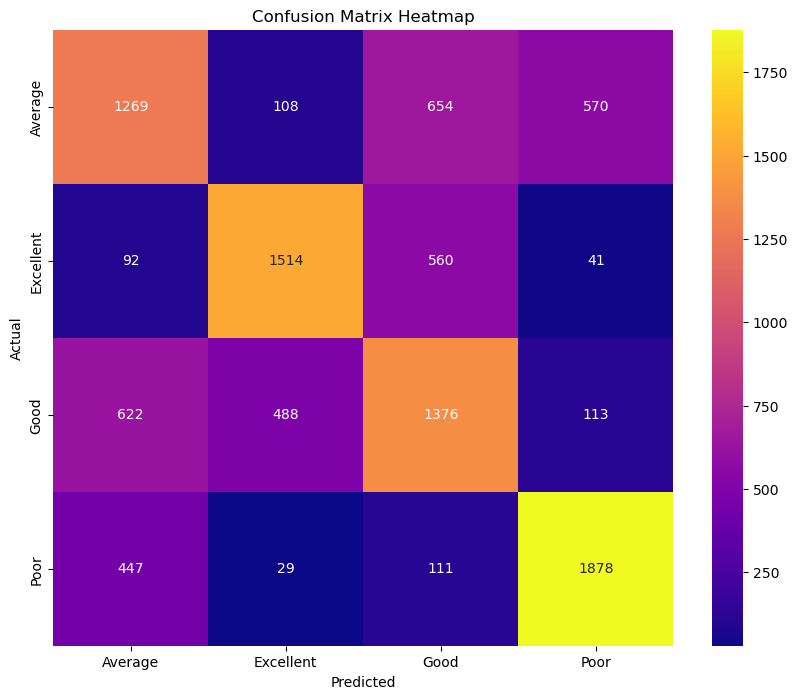

In [178]:
# Plotting heatmap of confusion matrix 

import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Class labels
class_labels = ['Average', 'Excellent', 'Good', 'Poor']

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='plasma', xticklabels=class_labels, yticklabels=class_labels)

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix Heatmap')

plt.show()

Our logistic regression model ran, and we got a test accuracy abou6 67% and a train accuracy of about 61%. This seems like a good start since we haven't done any hyperparameter tuning or more advanced feature selection. Additionally, the gap between the train and test accuracy is fairly small, which indicates the model is not overfitting. The confusion matrix and the classification report also provide additional insights into how well the model is performing for each category. 

#### Classification Report Summary:

**Accuracy**: 61.1%.

**Precision**: True positive predictions vs total predicted positives 
  - **Excellent**: 0.71
  - **Poor**: 0.72
  - **Good**: 0.51
  - **Average**: 0.52
  
**Recall**: True positive predictions vs total actual positives

  - **Excellent**: 0.69
  - **Poor**: 0.76
  - **Good**: 0.53
  - **Average**: 0.49
  
**F1-Score**: 
  - **Excellent**: 0.70
  - **Poor**: 0.74
  - **Good**: 0.52
  - **Average**: 0.50


#### Observations:

- The model has a higher precision and recall for the "Excellent" and "Poor" categories, indicating that it can identify these classes more reliably.
- The model struggles a bit more with the "Good" and "Average" categories, suggesting that these reviews may contain features that are harder for the model to distinguish.
- The F1-scores also reflect this trend, being higher for the "Excellent" and "Poor" categories and lower for "Good" and "Average."

Overall, the model performs decently with an accuracy of about 61%, but there is room for improvement, especially in correctly classifying "Good" and "Average" reviews.

#### Next Steps 
1. Try more advanced algorithms to improve accuracy.
2. Perform hyperparameter tuning to optimize the model.
3. Investigate why some categories are not as well-classified 